In [1]:
!pip install biopython
!pip install transformers

     |████████████████████████████████| 2.3MB 2.8MB/s 
     |████████████████████████████████| 317kB 2.8MB/s 
     |████████████████████████████████| 645kB 35.1MB/s 
     |████████████████████████████████| 860kB 35.7MB/s 
     |████████████████████████████████| 1.0MB 35.7MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.35-cp36-none-any.whl size=883999 sha256=7142151a45c8a7d2e25d6b4c11f6cf74cef9d93dc9d657e3a87675ab9835300c
  Stored in directory: /root/.cache/pip/wheels/63/2a/db/63e2909042c634ef551d0d9ac825b2b0b32dede4a6d87ddc94
Successfully built sacremoses


In [2]:
import os
import gzip
from Bio import SeqIO
from Bio.Data import CodonTable

import torch

from transformers import GPT2Config, GPT2Model, GPT2LMHeadModel

In [3]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
def check_known_protein(protein_description):
    """filter out hypothetical and putative proteins"""
    is_hypothetical = ('hypoth' in protein_description or 'hetical' in protein_description) # deals with most common misspellings of "hypothetical"
    is_putative = 'putative' in protein_description
    is_known = (not is_hypothetical) and (not is_putative)
    return is_known

def get_CDS_locations(genome_path):
    """exctracts gene locations and seqs from known protein coding genes, only non-hypothetical"""
    gene_loc_list = []
    gene_seq_list = []
    with gzip.open(genome_path, 'rt') as handle: # open file
        for record in SeqIO.parse(handle, "genbank"): # parse each record within file
            feature_list = record.features
            CDS_list = [x for x in feature_list if x.type=='CDS'] # get all CDS features in record
            for CDS in CDS_list:
                try:
                    protein_description = CDS.qualifiers['product'][0]
                    if check_known_protein(protein_description): # only use non-hypothetical proteins
                        gene_loc = CDS.location
                        gene_loc_list.append(gene_loc)

                        gene_seq = CDS.extract(record.seq) # extract locations of CDS
                        gene_seq_list.append(gene_seq)
                except:
                    pass

    return gene_loc_list, gene_seq_list

In [7]:
# load fasta sequence
d = "drive/My Drive/Colab Notebooks/smaug/data/ecoli_MG1655"
genome_path = os.path.join(d, "GCF_000005845.2_ASM584v2_genomic.fna.gz")

with gzip.open(genome_path, 'rt') as handle:
    for record in SeqIO.parse(handle, "fasta"):
        seq = record.seq

# get gene locations
gbff_path = os.path.join(d, "GCF_000005845.2_ASM584v2_genomic.gbff.gz")
gene_loc_list, gene_seq_list = get_CDS_locations(gbff_path)

# total genes and example loc
print(len(gene_loc_list))
print(gene_loc_list[300])

3532
[381350:381716](+)


In [6]:
# all code needed to produce score for "geneness" of amino acid sequence

# mount
from google.colab import drive
drive.mount('/content/drive')
# modeldir = "drive/My Drive/Colab Notebooks/smaug/data/models"
modeldir = "drive/My Drive/Colab Notebooks/smaug/data/models/10-25-19_morning_20"

# load model
model = GPT2LMHeadModel.from_pretrained(modeldir).to('cuda')

# score sequence
def score_seq(aa_seq_string):
    aa_seq_string = aa_seq_string[:40] ################### TODO implement shingles
    
    token = tokenize_aa_seq(aa_seq_string)
    input_ids = token.unsqueeze(0).to('cuda')

    logits = model(input_ids)[0]
    soft = torch.exp(logits)
    softsum = torch.sum(soft, axis=2).view(len(soft),-1,1)
    softproportion = soft/softsum

    predval = torch.roll(torch.argmax(softproportion, axis=2), 1) # remember prediction offset by 1
    
    correctmask = predval == input_ids[:] # why no offset here?
    hardcorrect = torch.sum(correctmask).item()
    totalcorrect = logits.shape[0]*logits.shape[1]

    softcorrect = 0
    for i in range(input_ids.shape[0]):
        for j in range(input_ids.shape[1] - 1): # remember prediction offset by 1
            softcorrect += softproportion[i, j, input_ids[i,j+1]]
    softcorrect = softcorrect.item()

    softproportion = softcorrect/totalcorrect 
    hardproportion = hardcorrect/totalcorrect

    return softproportion # hard proportion might work better on long sequences

def tokenize_aa_seq(aa_seq):
    """Convert amino acid letters to integers. Can also use murphy's reduced aa alphabet later"""
    table = {"L":1,
             "V":2,
             "I":3,
             "M":4,
             "C":5,
             "A":6,
             "G":7,
             "S":8,
             "T":9,
             "P":10,
             "F":11,
             "Y":12,
             "W":13,
             "E":14,
             "D":15,
             "N":16,
             "Q":17,
             "K":18,
             "R":19,
             "H":20,
             "X":0, # get rid of these
             "B":0,
             "*":0}
    tokenized = torch.tensor([table[aa] for aa in aa_seq])
    return tokenized

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# find all ORFs in all reading frames
def find_ORFs(aa_seq, minimum_length):
    """find positions of all open reading frames in all reading frames"""
    # ASSUMES AMINO ACID SEQUENCE IS 5' to 3'
    ORF_startstop = []
    started = False
    startpos = -1
    for i, c in enumerate(aa_seq):
        if c == "M" and not started:
            startpos = i
            started = True
            continue
        if c == "*":
            if started and (i-startpos >= minimum_length):
                ORF_startstop.append((startpos, i))
            started = False
    return ORF_startstop # TODO may be better to use dict rather than tuple list


# amino acid seqs for all 6 reading frames
# trimming last nucs to ensure multiple of 3
aa_seq_0f = str(seq[:-(len(seq)%3)].translate(table=11, to_stop=False))
aa_seq_1f = str(seq[1:-((len(seq)-1)%3)].translate(table=11, to_stop=False))
aa_seq_2f = str(seq[2:-((len(seq)-2)%3)].translate(table=11, to_stop=False))
aa_seq_0r = str(seq.reverse_complement()[:-(len(seq)%3)].translate(table=11, to_stop=False)) #TODO cut end off before or after reverse complement?
aa_seq_1r = str(seq[1:].reverse_complement()[:-((len(seq)-1)%3)].translate(table=11, to_stop=False))
aa_seq_2r = str(seq[2:].reverse_complement()[:-((len(seq)-2)%3)].translate(table=11, to_stop=False))

# trim trailing aa's to get multiple of 3
aa_seq_0f = aa_seq_0f[:-(len(aa_seq_0f)%3)]
aa_seq_1f = aa_seq_0f[:-(len(aa_seq_1f)%3)]
aa_seq_2f = aa_seq_0f[:-(len(aa_seq_2f)%3)]
aa_seq_0r = aa_seq_0f[:-(len(aa_seq_0r)%3)]
aa_seq_1r = aa_seq_0f[:-(len(aa_seq_1r)%3)]
aa_seq_2r = aa_seq_0f[:-(len(aa_seq_2r)%3)]


# ORFs starts and stops in all reading frames, use to access sequence
minimum_length = 10
ORF_0f = find_ORFs(aa_seq_0f, minimum_length)
ORF_1f = find_ORFs(aa_seq_1f, minimum_length)
ORF_2f = find_ORFs(aa_seq_2f, minimum_length)
ORF_0r = find_ORFs(aa_seq_0r, minimum_length)
ORF_1r = find_ORFs(aa_seq_1r, minimum_length)
ORF_2r = find_ORFs(aa_seq_2r, minimum_length)

# standardize coordinates of all ORFs, use to check for overlaps
l = len(ORF_0f) ### TODO aa overlap vs nucleotide overlap is complicated, think about how to make this exact and formal, though this may not matter toooo much in real data
ORF_0f_standard = ORF_0f
ORF_1f_standard = [(x[0]+1, x[1]+1) for x in ORF_1f]
ORF_2f_standard = [(x[0]+2, x[1]+2) for x in ORF_2f]
ORF_0r_standard = [(l-x[1]-1, l-x[0]-1) for x in ORF_0r] # NOTE first number is actually stop codon in all reverse frames
ORF_1r_standard = [(l-x[1]-1-1, l-x[0]-1-1) for x in ORF_1r]
ORF_2r_standard = [(l-x[1]-1-2, l-x[0]-1-2) for x in ORF_2r]

# # example seq access
# foo = int(ORF_2f[0][0])
# bar = int(ORF_2f[0][1])
# print(foo, bar)
# print(aa_seq_2f[foo:bar+1])


In [0]:
# check if predicted gene matches 3' end, also if 5' (correct start codon is harder)
allstops_real = 
allstarts_real = 

In [0]:
for i in range(10):
    print(gene_loc_list[i])
    print(gene_loc_list[i].start)


[189:255](+)
189
[336:2799](+)
336
[2800:3733](+)
2800
[3733:5020](+)
3733
[5233:5530](+)
5233
[5682:6459](-)
5682
[8237:9191](+)
8237
[9305:9893](+)
9305
[9927:10494](-)
9927
[10829:11315](+)
10829


In [0]:
# example scores
import matplotlib.pyplot as plt
# score_0f = [score_seq(aa_seq_0f[x[0]:x[1]][::-1]) for x in ORF_0f[:1000]]
# score_1f = [score_seq(aa_seq_1f[x[0]:x[1]][::-1]) for x in ORF_1f[:1000]]
score_0r = [score_seq(aa_seq_0r[x[0]:x[1]]) for x in ORF_0f[:300]] # TODO CHECK WHETHER REVERSE OF STRING SHOULD BE USED FOR R seqs


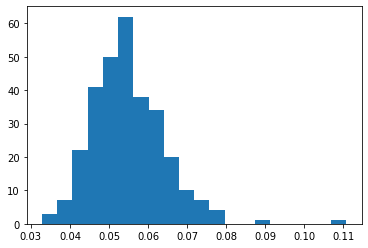

In [0]:
# plt.hist(score_0f, bins=100)
# plt.show()
# plt.hist(score_1f, bins=100)
# plt.show()
plt.hist(score_0r, bins=20)
plt.show()

In [0]:
# greedy search to find non-overlapping genes based solely on length
